In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Create the classifier dictionary

In [5]:
birddict ={}
F = open('data/nabirds/classes.txt','r') 
for line in F: 
    id,name = line.split(None, 1)
    birddict.update({id.zfill(4):name})

In [23]:
birddict['0483']

'Tricolored Heron\n'

In [6]:
path_img = 'data/nabirds/images/'
fnames = fnames = get_image_files(path_img, recurse=True)
fnames[:5]

def label_bird(filename):
    pat = r"\d{4}"
    m=re.search(pat,str(filename))
    return birddict[m.group(0)].replace('\n', ' ').replace('\r', '')

def load_train_test_split(dataset_path=''):
  train_images = []
  test_images = []
  
  with open(os.path.join(dataset_path, 'train_test_split.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      is_train = int(pieces[1])
      if is_train:
        train_images.append(image_id)
      else:
        test_images.append(image_id)
        
  return train_images, test_images 

## Load data into the ImageDataBunch
Each image is labeled using the label_bird function that checks the filename against the dictionary of filenames | classes.

In [12]:
data = ImageDataBunch.from_name_func(path_img, fnames, label_func=label_bird, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)
doc(ImageDataBunch)


class ImageDataBunch [source] [test] ImageDataBunch ( train_dl : DataLoader , valid_dl : DataLoader , fix_dl : DataLoader = None , test_dl : Optional [ DataLoader ]= None , device : device = None , dl_tfms : Optional [ Collection [ Callable ]]= None , path : PathOrStr = '.' , collate_fn : Callable = 'data_collate' , no_check : bool = False ) :: DataBunch 
 
 × No tests found for ImageDataBunch . To contribute a test please refer to this guide and this discussion . DataBunch suitable for computer vision. 
 Show in docs

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


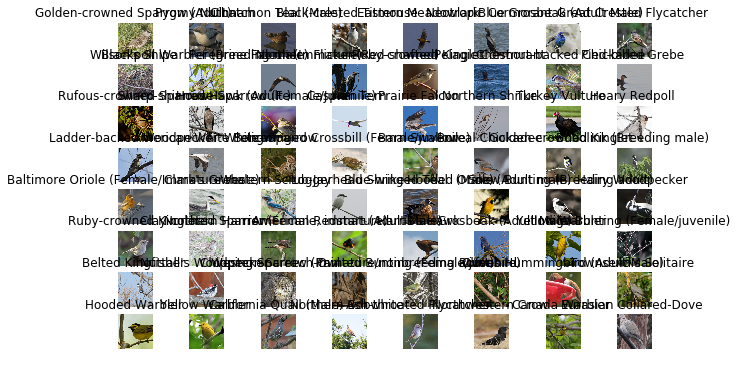

In [63]:
data.show_batch(rows=20, figsize=(10,6))

## First training

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [58]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.089032,2.325561,0.573208,06:52
1,2.172828,1.562689,0.409596,06:59
2,1.733163,1.288689,0.337315,06:57
3,1.491399,1.225109,0.323723,06:57


In [59]:
learn.save('stage-1')

## Results

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

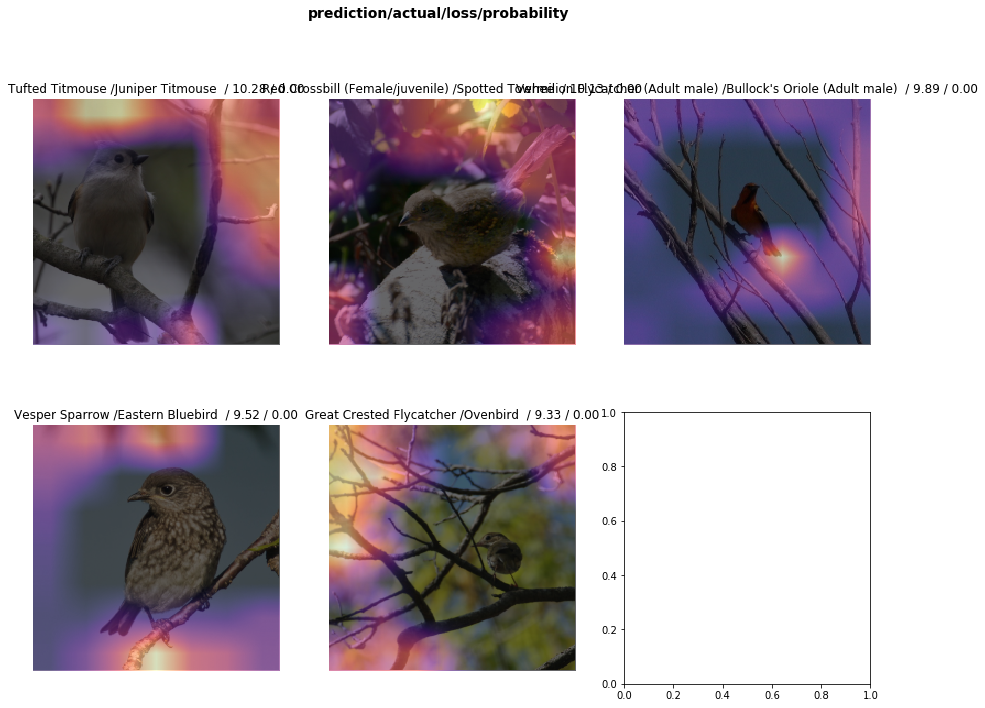

In [13]:
interp.plot_top_losses(5, figsize=(15,11), heatmap=True)

## Fine tuning

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


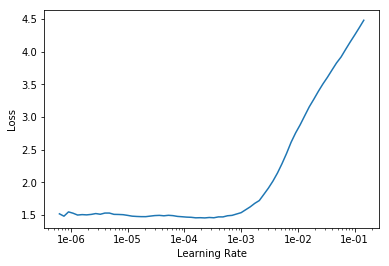

In [18]:
learn.recorder.plot()

In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.449206,0.895556,0.236100,08:40
1,1.359423,0.878392,0.231672,07:47


In [20]:
learn.save('stage-2')

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

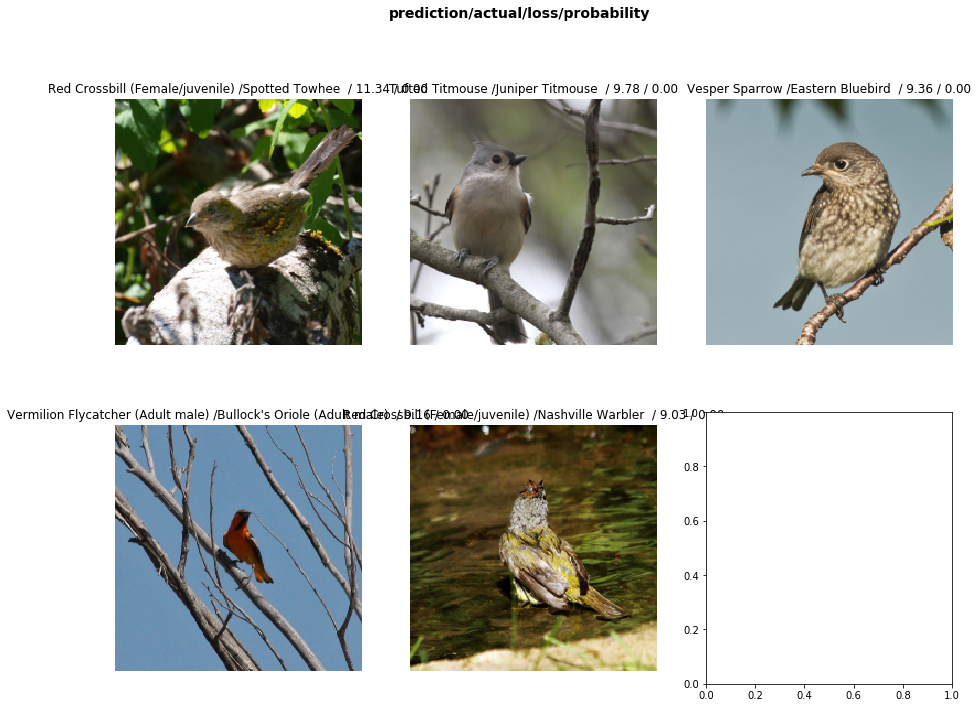

In [22]:
interp.plot_top_losses(5, figsize=(15,11), heatmap=False)

# Resnet 50

In [7]:
data = ImageDataBunch.from_name_func(path_img, fnames, label_func=label_bird, ds_tfms=get_transforms(), size=299, bs=bs//2).normalize(imagenet_stats)


In [8]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [26]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,3.077123,2.356307,0.543451,12:59
1,2.092931,1.480169,0.402080,13:02
2,1.687559,1.219347,0.329695,12:58
3,1.449593,1.021743,0.281096,12:57
4,1.182892,0.899543,0.249794,12:57
5,0.976300,0.801218,0.225700,12:58
6,0.882999,0.749580,0.209329,12:57
7,0.781527,0.734733,0.205725,12:59


In [27]:
learn.save('stage-1-50')

In [28]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,2.073518,1.635189,0.412685,16:54
1,1.610011,1.137363,0.306219,16:53
2,0.980002,0.696323,0.198723,16:55
3,0.613227,0.568189,0.163818,16:54


In [29]:
learn.save('stage-2-50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


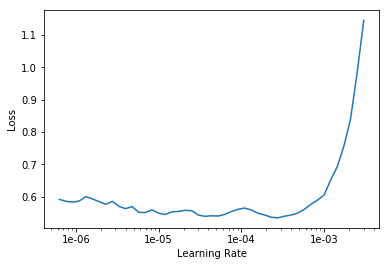

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.519778,0.559001,0.159699,16:53
1,0.505820,0.542377,0.155478,16:54
2,0.459787,0.533842,0.153727,16:55
3,0.425723,0.532149,0.152904,16:53


In [33]:
learn.save('stage-3-50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


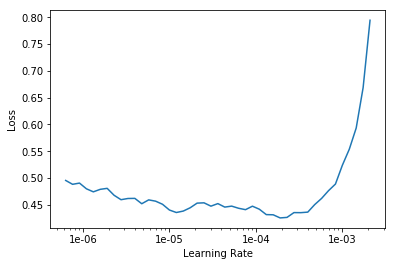

In [34]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.460634,0.563868,0.164745,16:52
1,0.513169,0.556396,0.161759,16:53
2,0.401801,0.520453,0.148476,16:53
3,0.332307,0.511144,0.145696,16:54


In [36]:
learn.save('stage-4-50')